In [1]:
from fco2models.models import UNet2DModelWrapper, MLPNaiveEnsemble
from fco2models.ueval import load_models
from fco2models.umeanest import MLPModel

model_info = {
    'xco2_100': ['../models/augm/', 'e_100.pt', UNet2DModelWrapper],
    'sota_ensemble': ['../models/sota_ensemble/', 'e_30.pt', MLPNaiveEnsemble],
}
models = load_models(model_info)

In [2]:
import pandas as pd
import numpy as np
from fco2models.utraining import prep_df, make_monthly_split
DATA_PATH = "../data/training_data/"
df = pd.read_parquet(DATA_PATH + "SOCAT_1982_2021_grouped_colloc_augm_bin.pq", engine='pyarrow')
df = prep_df(df, bound=True)[0]
_, mask_val, mask_test = make_monthly_split(df)
df_val = df.loc[df.expocode.map(mask_val), :]
df_test = df.loc[df.expocode.map(mask_test), :]

2025-06-11 17:26:34,376 - INFO - salinity stacking
2025-06-11 17:26:34,439 - INFO - adding positional and temporal encodings
2025-06-11 17:26:36,179 - INFO - add climatology data
2025-06-11 17:26:49,359 - INFO - adding xco2 data
2025-06-11 17:26:53,361 - INFO - removing xco2 levels from fco2rec_uatm
2025-06-11 17:26:53,460 - INFO - replacing outliers with Nans, fco2rec_uatm > 400


Splitting data into train/val/test with parameters: month_step=7, val_offset=3, leave_out_2021=False


In [3]:
assert df_val.expocode.isin(df_test.expocode).sum() == 0, "expocode ids overlap between train and test sets"

In [4]:
import torch
def normalize(df, stats, mode):
    for i in range(1, len(df.columns)): # first column is the target
        col = df.columns[i - 1]
        # print(f"Normalizing {col} with {mode}")
        if mode == 'min_max':
            # print(f"Min: {stats['mins'][i]}, Max: {stats['maxs'][i]}")
            df[col] = 2 * (df[col] - stats['mins'][i]) / (stats['maxs'][i] - stats['mins'][i]) - 1
        elif mode == 'mean_std':
            df[col] = (df[col] - stats['means'][i]) / stats['stds'][i]
        else:
            raise ValueError(f"Unknown mode {mode}")
    return df

def diffusion_step(model, noise_scheduler, x, t, jump):
    # Get model pred
    sample = x[:, 0:1, :]  # Assuming the first channel is the sample
    with torch.no_grad():
        residual = model(x, t, return_dict=False)[0]
    output_scheduler = noise_scheduler.step(residual, t, sample)
    if jump is not None:
        x_0 = output_scheduler.pred_original_sample
        if t < jump:
            sample = x_0
        else:
            sample = noise_scheduler.add_noise(x_0, torch.randn_like(sample), t - jump)
    else:
        # Update sample with step
        sample = output_scheduler.prev_sample
    return sample


def step_and_collocate(model, t, dataloader, noise_scheduler, n_recs, expo_ids, windows, recs):
    samples = []
    device = "cuda" if torch.cuda.is_available() else "cpu"
    for batch in dataloader:
        batch = batch.to(device)
        sample = diffusion_step(model, noise_scheduler, batch, t, jump=20)
        samples.append(sample.cpu().numpy())

    samples = np.concatenate(samples, axis=0).squeeze(axis=1)
    rec_dfs = []
    for i in range(n_recs):
        rec_df = pd.DataFrame({
            'expocode': expo_ids[recs == i].flatten(),
            'window_id': windows[recs == i].flatten(),
            f'rec_{i}': samples[recs == i].flatten()
        })
        rec_df.set_index(['expocode', 'window_id'], inplace=True)
        rec_dfs.append(rec_df)
    
    sample_df = pd.concat(rec_dfs, axis=1)
    return sample_df

from fco2models.ueval import   get_expocode_map
def init_denoise_df(df, n_recs=10):
    """
    Initialize a DataFrame for denoising with the required columns.
    """
    rec_cols = [f'rec_{i}' for i in range(n_recs)]
    df.loc[:, rec_cols] = np.random.randn(len(df), n_recs)  # Random values for recs
    #df.loc[:, 'window'] = df.groupby('expocode').cumcount()  # Create a window column
    df.loc[:, 'expocode_id'] = df['expocode'].map(get_expocode_map(df))

    return df

from fco2models.utraining import get_segments
def segment_rec_df(df, predictors, n_recs, segment_len=64):
    """
    Segment the DataFrame into smaller chunks for processing.
    """
    segments = []
    cols =  predictors + ['expocode_id', 'window_id']
    for i in range(n_recs):
        rec = f'rec_{i}'
        segments_rec = get_segments(df, [rec] + cols)
        rec_col = np.full_like(segments_rec[:, 0:1, :], i)
        segments_rec = np.concatenate([segments_rec, rec_col], axis=1)
        segments.append(segments_rec)

    segments = np.concatenate(segments, axis=0)
    return segments


from tqdm import tqdm
from torch.utils.data import DataLoader
from fco2models.utraining import normalize_dss
def denoise_df(df, model_info, n_recs, jump=20):
    params = model_info['params']
    predictors = params['predictors']
    model = model_info['model']
    noise_scheduler = model_info['noise_scheduler']
    
    t_loop = tqdm(noise_scheduler.timesteps[::jump], desc="Denoising steps")
    stats = {
        'means': params['train_means'],
        'stds': params['train_stds'],
        'mins': params['train_mins'],
        'maxs': params['train_maxs'],
    }
    
    df.loc[:, predictors] = normalize(df.loc[:, predictors], stats, params['mode'])
    denoise_df = init_denoise_df(df, n_recs=n_recs)
    rec_cols = [f'rec_{i}' for i in range(n_recs)]

    model.eval()
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    for t in t_loop:
        ds = segment_rec_df(denoise_df, predictors, n_recs)
        
        expo_ids = ds[:, -3, :].astype(int)
        windows = ds[:, -2, :].astype(int)
        recs = ds[:, -1, :].astype(int)

        model_input = torch.from_numpy(ds[:, :-3, :]).float().to(model.device)
        dataloader = DataLoader(model_input, batch_size=64, shuffle=False)
        sample_df = step_and_collocate(model, t, dataloader, noise_scheduler, n_recs, expo_ids, windows, recs)

        denoise_df.set_index(['expocode_id', 'window_id'], inplace=True)
        # nan_mask = sample_df[rec_cols[0]].isna()
        # sample_df = sample_df.loc[~nan_mask, :]
        denoise_df.loc[sample_df.index, rec_cols] = sample_df[rec_cols]
        denoise_df.reset_index(inplace=True)
    
    return denoise_df

In [5]:
model_info = models['xco2_100']
noise_scheduler = model_info['noise_scheduler']
predictors = model_info['params']['predictors']
model = model_info['model']

In [ ]:
expocodes = ["AG5W20141113"]
n_recs = 10
ds = denoise_df(df_val.loc[df_val.expocode.isin(expocodes), : ].copy(), model_info, n_recs=n_recs)

Denoising steps:   0%|          | 0/50 [00:00<?, ?it/s]

Denoising steps: 100%|██████████| 50/50 [00:28<00:00,  1.73it/s]


<Axes: >

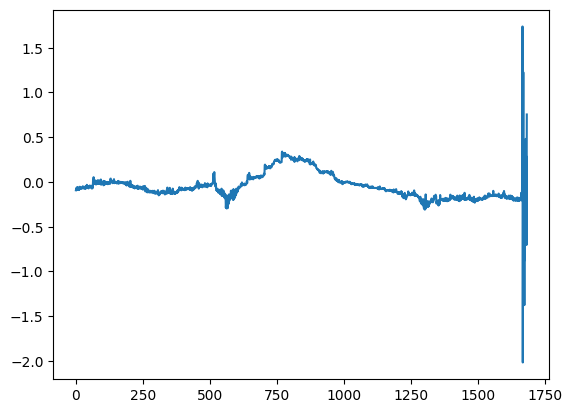

In [7]:
import matplotlib.pyplot as plt
ds.rec_2.plot()

In [8]:
from torch.utils.data import TensorDataset, DataLoader
def get_samples_ensemble(df, model_info):
    params = model_info['params']
    predictors = params['predictors']
    stats = {
        'means': params['train_means'],
        'stds': params['train_stds'],
        'mins': params['train_mins'],
        'maxs': params['train_maxs'],
    }
    df.loc[:, predictors] = normalize(df.loc[:, predictors], stats, params['mode'])

    model = model_info['model']
    ds = torch.from_numpy(df.loc[:, predictors].values).float()
    print(ds.shape)
    ds = TensorDataset(ds.unsqueeze(-1))
    dataloader = DataLoader(ds, batch_size=128, shuffle=False)
    samples = []
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    # _, samples = predict_mean_eval(model, dataloader)
    for batch in tqdm(dataloader, desc="Ensemble sampling"):
        batch = batch[0].to(device)
        with torch.no_grad():
            sample = model(batch, 0, return_dict=False)[0]
        samples.append(sample.cpu().numpy())
    samples = np.concatenate(samples, axis=1)

    print(f"Samples shape: {samples.shape}")
    return samples 

from fco2models.umeanest import predict_mean_eval
from fco2models.ueval import rescale
samples = get_samples_ensemble(df_val.copy(), models['sota_ensemble'])
params = models['sota_ensemble']['params']
samples = rescale(samples.reshape(-1, 1), params, params['mode']).reshape(5, -1)

torch.Size([790563, 12])


Ensemble sampling: 100%|██████████| 6177/6177 [00:32<00:00, 192.05it/s]

Samples shape: (5, 790563, 1, 1)


In [9]:
mlp_pred_cols = [f'mlp_{i}' for i in range(samples.shape[0])]
df_val.loc[:, mlp_pred_cols] = samples.T

<Axes: >

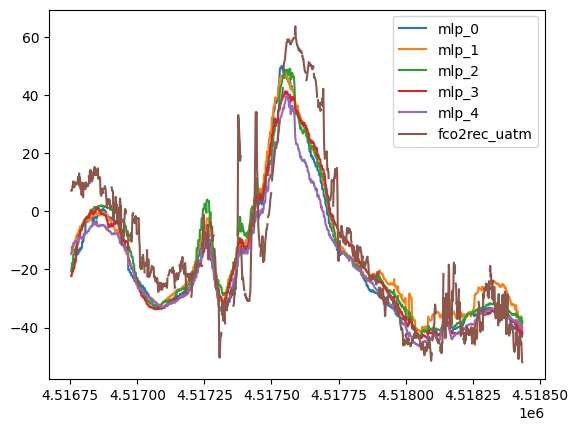

In [11]:
df_val.loc[df_val.expocode == "AG5W20141113", mlp_pred_cols + ['fco2rec_uatm']].plot()

In [16]:
dm_recs = [f'rec_{i}' for i in range(10)]
df_val.loc[:, dm_recs] = ds.loc[:, dm_recs]